Installing Dependencies
=======================

**The recommended way is to install ___Miniconda___ and install the dependencies in the conda environment**

* Install miniconda and change python version form 3.7 to 3.6. Run `conda install python=3.6` to install Python 3.6.
* To install ***Tomophantom*** module run `conda install tomophantom -c ccpi` in the miniconda environment
 > **NOTE**: *Tomophatom library requires python ver. 2.7/3.5/3.6* and can only be installed on linux64 using the above command. For more instructions see [Tomophanton official git repository](https://github.com/dkazanc/TomoPhantom)
* For the latest ***ASTRA-Toolbox installation*** run `conda install -c astra-toolbox/label/dev astra-toolbox` in the terminal. For further installation instruction and documentation check [here](https://www.astra-toolbox.com/docs/install.html)
* To visualize the projection and volume geometries it's recommended to install `astra_plot` module by running `python setup.py install`. You can download it manually from the [website](https://www.astra-toolbox.com/files/misc/astra_plot_ICTMS_201907.zip).
* Install numpy and matplotlib by either `pip install PACKAGE_NAME` or `conda install PACKAGE_NAME` commands.

## Importing the required modules

In [1]:
import tomophantom
from tomophantom import TomoP3D
import astra    
import matplotlib.pyplot as plt  ## For image visualization 
import numpy as np
import astra_plot   ### To visualize projection and volume geometries 
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/optimus/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## To test the installation run `astra.test()`:

This should then display output similar to one of the following, depending on if you have a NVIDIA GPU with CUDA installed or not. 

```
Getting GPU info... GPU #0: GeForce GTX 1070, with 8119MB
Testing basic CPU 2D functionality... Ok
Testing basic CUDA 2D functionality... Ok
Testing basic CUDA 3D functionality... Ok
```

Or 

```
No GPU support available
Testing basic CPU 2D functionality... Ok
```

> **NOTE**: NVIDIA GPU is must for 3D reconstruction to work. Since, all  ASTRA 3D reconstruction algorithms are implemented using CUDA.

In [2]:
astra.test()

## Creating a __3D Phantom__ \& visualizing it.

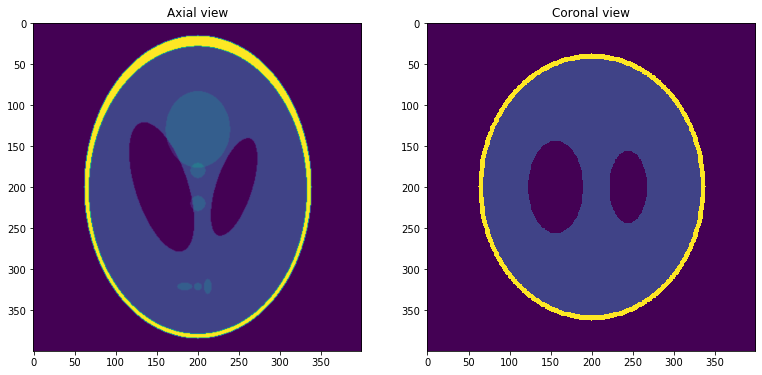

In [3]:
model = 13  ##Shepp-logan Phantom in the "Phantom3DLibrary.dat" file
path_library3D = "Phantom3DLibrary.dat"

N_size = 400

phantom = TomoP3D.Model(model, N_size, path_library3D)

slice_ = int(0.5*N_size)

plt.figure(figsize = [20,30])
plt.subplot(131)
plt.imshow(phantom[slice_,:,:],vmin=0, vmax=1,interpolation = "gaussian")
plt.title('Axial view')

plt.subplot(132)
plt.imshow(phantom[:,slice_,:],vmin=0, vmax=1)
plt.title('Coronal view')


plt.show()

## Analytical Projection Data at different angles

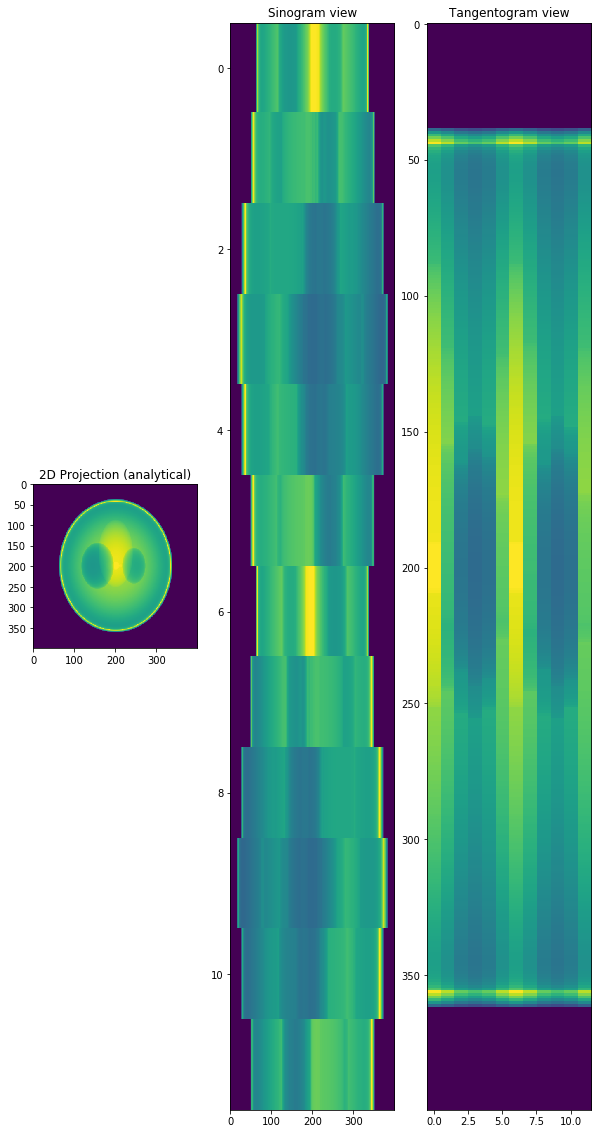

In [4]:
angles = np.arange(0, 2*np.pi, np.pi/6,dtype = "float32")   # in radian
angles_deg = np.arange(0 , 360,30,dtype = "float32")  # in degree

#--------------------------------------
det_row = 400  ## horizontal detector size
det_col = 400  ## vertical detector size
#--------------------------------------

projData =  TomoP3D.ModelSino(model, N_size, det_col, det_row, angles_deg, path_library3D)

#--------------------------------------

intens_max = 100
plt.figure(figsize = [10,20])
plt.subplot(131)
plt.imshow(projData[:,0,:],vmin=10, vmax=intens_max)
plt.title('2D Projection (analytical)')
plt.subplot(132)
plt.imshow(projData[slice_,:,:],vmin=10, vmax=intens_max,aspect = "auto")
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData[:,:,slice_],vmin=10, vmax=intens_max,aspect = "auto")
plt.title('Tangentogram view')
plt.show()

## Creating Projection and the Volume Geometry

In [ ]:
#----------Distance between two adjacent detector pixels----------
detector_width = 1   
detector_height = 1
#-------Number of detector pixels-------------
det_row = 400
det_col = 400
#-------------------------
source_origin = 500
origin_det    = 300
#-------------------------

######## Creating Projection Geometry ##########
proj_geom = astra.create_proj_geom('cone',detector_width, detector_height, det_row, det_col, angles, source_origin, origin_det)

######## Creating Volume geometry ##################
vol_geo  = astra.create_vol_geom(200,200,200)

## Visualizing the Geometry

type: cone
detector spacing: [1, 1]
detector px: [400, 400]
angle lo: 0.0
angle hi: 5.759586811065674
# angles: 12
DistanceOriginDetector 300
DistanceOriginSource 500


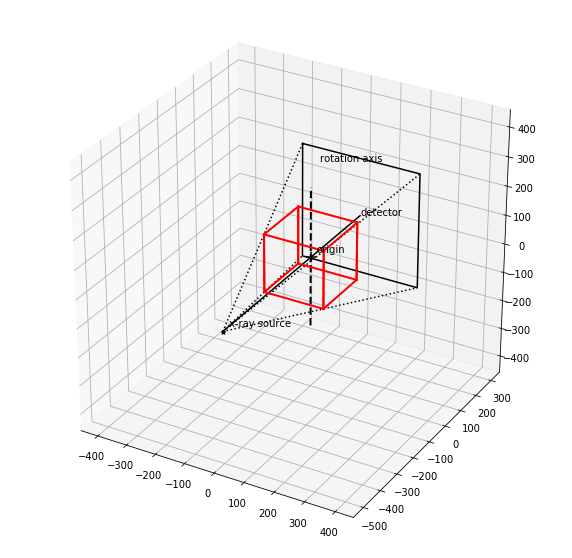

In [5]:
#----------- Visualizing Projection and Volume Geometry- ------------
plt.rcParams['figure.figsize'] = [10, 10]
plot_proj = astra_plot.plot_geom(proj_geom)
#plt.show()
#--------------------------------------------

astra_plot.plot_geom(vol_geo,plot_proj)
plt.show()

In [6]:
# Data objects for input, output

proj_id =astra.data3d.create('-proj3d',proj_geom,projData)
rec_id =astra.data3d.create('-vol',vol_geo)

proj_get = astra.data3d.get(proj_id)
rec_get  = astra.data3d.get(rec_id)

algorithm = "FDK_CUDA"   ## the set of algorithms { "FP3D_CUDA" , "BP3D_CUDA" , "FDK_CUDA" , "SIRT3D_CUDA" , "CGLS3D_CUDA" }

cfg = astra.astra_dict(algorithm)

cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id

alg_id =astra.algorithm.create(cfg)
display(cfg)

# Run
no_iter = 100 # np of iterations

astra.algorithm.run(alg_id,no_iter)
rec = astra.data3d.get(rec_id)

{'type': 'FDK_CUDA', 'ReconstructionDataId': 2, 'ProjectionDataId': 1}

### Visualizing the reconstructed data

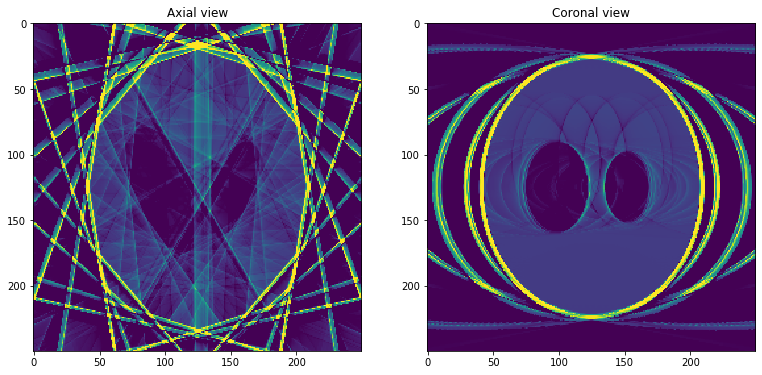

In [7]:
N_size = 250
slice_ = int(0.5*N_size)


vmax = 1.6 
vmin = 0.05 
#plt.gray()
plt.figure(figsize = [20,30])
plt.subplot(131)
plt.imshow(rec_image[slice_,:,:],vmin=vmin, vmax=vmax)
plt.title('Axial view')

plt.subplot(132)
plt.imshow(rec_image[:,slice_,:],vmin=vmin, vmax=vmax)
plt.title('Coronal view')

plt.show()